In [1]:
import os
from bs4 import BeautifulSoup, NavigableString, Tag 

from nltk.util import ngrams
from nltk import word_tokenize

import json
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as plt
import seaborn as sns

import collections
import csv
# from sets import Set # DEPRECATED

from datetime import datetime
from pytz import timezone

print "imported"

imported


In [2]:
# IMPORTS SPECIFIC TO TOPIC MODELING

import langid
import nltk
import re
import time
from collections import defaultdict
from configparser import ConfigParser
from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from string import digits
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
# from nltk.tag.api import TaggerI
# from nltk import word_tokenize, pos_tag
print "imported"

imported


### DESCRIPTIVES,  EXPLORATION, AND SELECTION

#### LOAD CSV

In [3]:
headers = ['outlet', 'date', 'text', 'citation']
news = pd.read_csv('data/newwords.csv', names=headers, infer_datetime_format=True, error_bad_lines=False, warn_bad_lines=True)
news.drop(['citation'], axis=1, inplace=True)
news = news[['date', 'outlet', 'text']]
news['date'] = pd.to_datetime(news['date']) # CONVERT STR DATE TO DATETIME
# news.set_index('date', inplace=True) # AND/OR, SET DATE AS INDEX
news.head()

,date,outlet,text
0,2015-09-16,CNN_Election,WHO'S STEADY HAND DO WE WANT ON TILLER IN THE ...
1,2015-09-16,CNN_Election,CANDIDATES AND ONE EXCELLENT MODERATOR JAKE TA...
2,2015-09-16,CNN_Election,YOU CAN'T GOVERN IF YOU CAN'T WIN. YOU CAN'T W...
3,2015-09-16,CNN_Election,THEM. ARE THEY ALL GOING TO BE LOCK STEP ON TH...
4,2015-09-16,CNN_Election,ADS. >> ARE THESE CONSERVATIVE GROUPS COMING O...


In [6]:
print news['text'][0]

WHO'S STEADY HAND DO WE WANT ON TILLER IN THE STORMY SEAS THAT WE FIND OURSELVES IN TODAY? GETTING SMALL GETTING -- MAKING IT LOOK LIKE IT'S JUST A HIGH SCHOOL ELECTION AND NAME CALLING AND ALL OF THOSE THINGS THAT CAN ACTUALLY TAKE YOU OUT OF THE CAMPAIGN TONIGHT. STAY BIG. I THINK THAT'S ONE OF THE THINGS WE WANT TO 


In [252]:
news['date'].describe()

count                    8655
unique                    414
top       2016-10-20 00:00:00
freq                      119
first     2015-09-16 00:00:00
last      2016-11-09 00:00:00
Name: date, dtype: object

#### VIEW SENTENCE VOLUME BY WEEK AND OUTLET

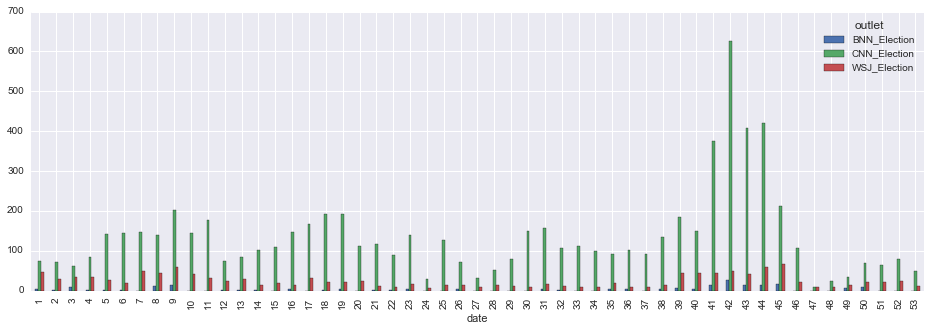

In [9]:
by_outlet_wk_ct = news.groupby(['outlet', news["date"].dt.week])['date'].count().unstack().fillna(0).T
by_outlet_wk_ct.plot(kind="bar", figsize=(16,5))

#### CHOOSE MONTHS

In [ ]:
# MONTH 1:
# 2016-7-20 - 2016-7-26
# 2016-7-27 - 2016-8-2
# 2016-8-3 - 2016-8-9
# 2016-8-10 - 2016-8-16

# MONTH 2: 
# 2016-8-17 - 2016-8-23
# 2016-8-24 - 2016-8-30
# 2016-8-31 - 2016-9-6
# 2016-9-7 - 2016-9-13

# MONTH 3:
# 2016-9-14 - 2016-9-20
# 2016-9-21 - 2016-9-27
# 2016-9-28 - 2016-10-4
# 2016-10-5 - 2016-10-11

# MONTH 4:
# 2016-10-12 - 2016-10-18
# 2016-10-19 - 2016-10-25
# 2016-10-26 - 2016-11-1
# 2016-11-2 - 2016-11-8

#### CREATE VIEWS

In [10]:
# ENTIRE CORPUS SPLIT BY OUTLET
cnn = news[news['outlet'] == 'CNN_Election']
bnn = news[news['outlet'] == 'BNN_Election']
wsj = news[news['outlet'] == 'WSJ_Election']

# CORPUS SPLIT BY MONTH WITH COMBINED OUTLET
month_a = news[(news['date'] >= '2016-7-20') & (news['date']<= '2016-8-16')]
month_b = news[(news['date'] >= '2016-8-17') & (news['date']<= '2016-9-13')]
month_c = news[(news['date'] >= '2016-9-14') & (news['date']<= '2016-10-11')]
month_d = news[(news['date'] >= '2016-10-12') & (news['date']<= '2016-11-8')]

#### SAVE VIEWS TO FILES

In [396]:
dfs = [cnn, bnn, wsj, month_a, month_b, month_c, month_d]
names = ['cnn', 'bnn', 'wsj', 'month_a', 'month_b', 'month_c', 'month_d']

for df, name in zip(dfs, names):
    df.to_csv('data/csv/all/' + name + '.csv', ) # ALL COLUMNS IN VIEW
    df.to_csv('data/strings/all/' + name + '.txt', columns=['text'], header=False, index=False) # TEXT ONLY

### PREPROCESSING TEXT, CREATING DICTIONARIES AND CORPORA

In [155]:
# include_dict = collections.OrderedDict()
# include_dict = {'full': True, 'unichars': False, 'bichars': False, 'misc': False, 
#                 'nltk': False, 'numbers': False, 'lemmas': False, 'low_fq': False}
# levels = ['full', 'uni', 'bi', 'misc', 'nltk', 'num', 'lemmas', 'freq'] # NOW USES KEYS IN STOP_DICT


tokenizer = RegexpTokenizer(r'\w+')

dfs = [cnn, bnn, wsj] #, month_a, month_b, month_c, month_d]
names = ['cnn', 'bnn', 'wsj'] #, 'month_a', 'month_b', 'month_c', 'month_d']

for df, name in zip(dfs, names):
    
    documents = [text for text in df['text']]
    documents = [tokenizer.tokenize(doc.lower()) for doc in documents ]
    documents = [ [token.decode('ascii', 'ignore') for token in doc] for doc in documents  ] # FIX UNICODE
    print name, len(documents), 'documents'

    stop_dict = create_stop_dict(documents)
    for level, (stoptype, stoplist) in enumerate(stop_dict.items()):
        
        if stoptype == 'lemmas':
            
            # print 'LEMMATIZING DOCUMENTS'
            documents = lemmatize_documents(documents)
        
        elif stoptype == 'freq': # REMOVE LOW FREQUENCY WORDS (TODO: REFACTOR TO FIT INTO STOP_DICT FX)
            
#             print 'REMOVING LOW FREQUENCY'
            documents = remove_low_frequency(documents)
            
        else:
#             print 'REMOVING stoptype.upper()'
            documents = remove_stopwords(documents, stoplist)
        
        # SAVE FREQUENCY COUNTS
        token_fqs = save_token_frequency(documents, 'data/freq/', name, level, stoptype)
        
        # SAVE TEXT AS STRINGS
#         save_tokenized_text(documents, 'data/tokens/', name, level)
        save_tokenized_text(documents, 'data/tokens/', name, level, stoptype)
        
        # SAVE DICT AND CORPORA
        save_nlp_files(documents, name, level, stoptype)
        
        unique_tokens = token_fqs.keys()
        all_tokens = list(token_fqs.elements())
                    
        print level, stoptype + ': ', 'STOPLIST:', len(stoplist), 'TOKENS:', len(all_tokens), 'UNIQUE:', len(unique_tokens)

    print ''

cnn 7160 documents
0 full:  STOPLIST: 0 TOKENS: 449576 UNIQUE: 17511
1 uni:  STOPLIST: 26971 TOKENS: 422605 UNIQUE: 17474
2 bi:  STOPLIST: 81539 TOKENS: 341066 UNIQUE: 17161
3 nltk:  STOPLIST: 153 TOKENS: 211443 UNIQUE: 17045
4 misc:  STOPLIST: 16 TOKENS: 203866 UNIQUE: 17030
5 num:  STOPLIST: 2931 TOKENS: 202599 UNIQUE: 16718
6 lemmas:  STOPLIST: 0 TOKENS: 202599 UNIQUE: 13614
7 freq:  STOPLIST: 0 TOKENS: 196079 UNIQUE: 7094

bnn 193 documents
0 full:  STOPLIST: 0 TOKENS: 5989 UNIQUE: 1911
1 uni:  STOPLIST: 409 TOKENS: 5580 UNIQUE: 1897
2 bi:  STOPLIST: 915 TOKENS: 4665 UNIQUE: 1837
3 nltk:  STOPLIST: 153 TOKENS: 3315 UNIQUE: 1747
4 misc:  STOPLIST: 16 TOKENS: 3252 UNIQUE: 1733
5 num:  STOPLIST: 62 TOKENS: 3229 UNIQUE: 1719
6 lemmas:  STOPLIST: 0 TOKENS: 3229 UNIQUE: 1518
7 freq:  STOPLIST: 0 TOKENS: 2272 UNIQUE: 561

wsj 1302 documents
0 full:  STOPLIST: 0 TOKENS: 46752 UNIQUE: 6727
1 uni:  STOPLIST: 3359 TOKENS: 43393 UNIQUE: 6698
2 bi:  STOPLIST: 7555 TOKENS: 35838 UNIQUE: 6559
3 n

#### FUNCTIONS

In [ ]:
def create_stop_dict(documents):
    
    stop_dict = collections.OrderedDict()
    
    stop_dict['full'] = []
    stop_dict['uni'] = [ w for doc in documents for w in doc if len(w)<=1] # INCLUDE ''
    stop_dict['bi'] = [ w for doc in documents for w in doc if len(w)==2]
    stop_dict['nltk'] = nltk.corpus.stopwords.words("english")
    stop_dict['misc'] = ['get', 'know', 'would', 'and', 'yet', 'due', 'one', 'way', 'also', \
                         'use', 'within', 'like', 'may', 'however', 'even', 'used']
#     stop_dict['numbers'] = [ [token for token in doc if len(token.strip(digits)) != len(token)] for doc in documents ]
    stop_dict['num'] = [ token for doc in documents for token in doc if len(token.strip(digits)) != len(token)]
    
    # NEED EMPTY LISTS SIMPLY FOR ITERATION BECAUSE WE'LL USE THE KEYS
    stop_dict['lemmas'] = []
    stop_dict['freq'] = []


    return stop_dict

def remove_stopwords(documents, stoplist):
    
    documents = [[token for token in doc if token not in stoplist] for doc in documents]
    
    return documents

def remove_digits(documents):
    
        # REMOVES WORDS THAT ARE NUMBERS ONLY
        documents = [ [token for token in doc if len(token.strip(digits)) == len(token)] for doc in documents ]
        
        return documents
    
def lemmatize_documents(documents):
    
    lemma = WordNetLemmatizer()
    
    tagged_docs = [[tagged_token for tagged_token in pos_tag(doc)] for doc in documents]
    
    lemmatized_docs = [[lemma.lemmatize(tagged_token[0], get_treebank_pos(tagged_token[1])) 
                          for tagged_token in tagged_doc] for tagged_doc in tagged_docs]
    
    return lemmatized_docs

# test_docs = [['say', 'said', 'saying', 'says'], ['hear', 'heard', 'hearing', 'hears']]
# lemmatize_documents(test_docs)
# # [['say', u'say', u'say', u'say'], ['hear', 'heard', 'hearing', 'hears']]

# MODIFIED FROM BELOW TO USE PENN TREEBANK POS STRINGS INSTEAD OF WORDNET
# ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v' vs. wordnet.ADJ, wordnet.VERB, wordnet.NOUN, WORDNET.ADV
# https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
# SEE HERE FOR TAGS: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

def get_treebank_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def remove_low_frequency(documents, frequency=1):
    
            # REMOVE WORDS THAT OCCUR ONLY ONCE
        token_frequency = defaultdict(int)

        # count all tokens
        for doc in documents:
            for token in doc:
                token_frequency[token] += 1

        # keep words that occur more than once
        documents = [ [token for token in doc if token_frequency[token] > frequency]
                        for doc in documents  ]
        
        return documents
    
def flatten_tokens(documents):
    
    flat_list = [item for sublist in documents for item in sublist]
    
    return flat_list


def save_token_frequency(documents, path, name, level, stoptype, flatten=True):
    
    if flatten:
        
        tokens = flatten_tokens(documents)
        
    else: 
        
        tokens = documents
    
    token_fqs = collections.Counter(tokens)

    cdf = pd.DataFrame.from_dict(token_fqs, 'index').reset_index()
    cdf.columns = ['token', 'frequency']
    
    filename = name + '_' + ('0' + str(level)) + '_' + stoptype
    cdf.to_csv(path + filename + '.csv', index=False)
    
    return token_fqs

# test_docs = [['say', 'said', 'saying', 'says', 'said'], ['hear', 'heard', 'hears', 'hearing', 'hears', 'hear', 'hears']]
# # # SHOULD SAVE FILE 'data/freq/outlet_00_test.csv' WITH TOKENS, FREQUENCY AS COLUMN LABEL PLUS 8 LINES
# # # AND RETURN THE TOKEN_FQS COUNTER
# save_token_frequency(test_docs, 'data/freq/', 'outlet', 0, 'test')


def save_tokenized_text(documents, path, name, level, stoptype):
    
    joined_tokens = [' '.join(doc) for doc in documents]

    joined_df = pd.DataFrame(joined_tokens, columns=['tokens'])
    
    filename = name + '_' + ('0' + str(level)) + '_' + stoptype
        
    joined_df.to_csv(path + filename + '.csv', index=False)
    
# test_docs = [['say', 'said', 'saying', 'says'], ['hear', 'heard', 'hearing', 'hears']]
# # SHOULD SAVE FILE 'data/tokens/outlet_00_test.csv' WITH TOKENS AS COLUMN LABEL PLUS LINES FROM TEST_DOCS
# save_tokenized_text(test_docs, 'data/tokens/', 'outlet', 1, 'test')


def save_nlp_files(documents, name, level, stoptype):
    
    filename = name + '_' + ('0' + str(level)) + '_' + stoptype
    
        # Sort words in documents
    for doc in documents:
        doc.sort()

    # Build a dictionary where for each document each word has its own id
    dictionary = corpora.Dictionary(documents)
    dictionary.compactify()
    # and save the dictionary for future use
#     print dictionary
    dictionary.save( 'data/dicts/' + filename + '.dict')

    # BUILD AND SAVE CORPUS
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    corpora.MmCorpus.serialize('data/corpora/' + filename + '.mm', corpus)
    
# save_nlp_files(test_docs, 'outlet', 0, 'test')
# # SHOULD SAVE data/corpora/outlet_00_test.mm/.index, data/dicts/outlet_00_test.dict

#### NON-LOOPED CODE FOR TESTING

In [156]:
test_docs = [['', 'say', 'said', 'saying', 'says'], ['hear', 'heard', '', 'hearing', 'hears'], []]

tokenizer = RegexpTokenizer(r'\w+')

df = bnn
name = 'bnn'
level = 'level_lemma'

documents = [text for text in df['text']]
documents = [tokenizer.tokenize(doc.lower()) for doc in documents ]
documents = [ [token.decode('ascii', 'ignore') for token in doc] for doc in documents  ] # FIX UNICODE

stop_dict = create_stop_dict(documents)
documents = remove_stopwords(documents, stop_dict['unichars'])
documents = lemmatize_documents(documents)

print name, len(documents), 'documents'
print ''

for tokens, lemmas in zip(documents[:2], lemma_docs[:2]):
    for token, lemma in zip(tokens, lemmas):
        print token, '--->', lemma
    print ''

#### UTILITY FUNCTION FOR POST LEMMATIZATION (USEFUL IN A SINGLE CIRCUMSTANCE)

In [479]:
names = ['cnn', 'bnn', 'wsj', 'month_a', 'month_b', 'month_c', 'month_d']

for name in names:
        
    input_file = 'data/freq/' + name + '_level_five.csv'
    output_file = 'data/lemmas/' + name + '_low_fq.csv'
    
    word_fqs = pd.read_csv(input_file)
    token_fqs = counter_from_dataframe(word_fqs)
    tokens = list(token_fqs.elements())

    post_lemmas = lemmatize_tokens(tokens)
    saved_token_fqs = save_token_frequency(post_lemmas, 'data/lemmas/', name, 'lemma', False)
    
    fq_gt_one = saved_token_fqs[saved_token_fqs['frequency'] > 1]
    
    fq_gt_one.to_csv(output_file, index=False)
    
def counter_from_dataframe(df):
    
    records = df.to_dict(orient='records')
    frequencies = {record['token']:record['frequency'] for record in records}
    counter = collections.Counter(frequencies)
    
    return counter

# word_fqs = pd.read_csv('data/freq/bnn_level_five.csv')
# token_fqs = counter_from_dataframe(word_fqs)
# tokens = list(token_fqs.elements())

# post_lemmas = lemmatize_tokens(tokens)
# saved_token_fqs = save_token_frequency(post_lemmas, 'data/lemmas/', 'bnn', 'lemma', False)